In [77]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

In [108]:
class number(data.Dataset):

    def __init__(self, negsize=2):
        super(number, self).__init__()
        num = 20
        self.length = num - 1
        self.negsize = negsize
        
    def __getitem__(self, index):
        neg = torch.randint(low=0, high=self.length, size=(self.negsize,))
        
        return torch.LongTensor([index]), torch.LongTensor([index+1]), neg
        
    def __len__(self):
        return self.length

In [163]:
class number2(data.Dataset):

    def __init__(self, negsize=2):
        super(number2, self).__init__()
        self.raw = torch.LongTensor([[0,1],[1,0],
                                     [1,2],[2,1],
                                     [0,2],[2,0],
                                     
                                     [3,4],[4,3],
                                     [4,5],[5,4],
                                     [5,3],[3,5],
                                     
                                     [0,3],[3,0]
                                    ])
        self.length = len(self.raw)
        self.negsize = negsize
        
    def __getitem__(self, index):
        neg = torch.randint(low=0, high=6, size=(self.negsize,))
        p_u, p_v = self.raw[index]
        
        return p_u, p_v, neg
        
    def __len__(self):
        return self.length

In [164]:
dataset = number2()
training_data = data.DataLoader(dataset, batch_size=6)

# 测试dataloader:
next(iter(training_data))

[tensor([0, 1, 1, 2, 0, 2]), tensor([1, 0, 2, 1, 2, 0]), tensor([[5, 3],
         [3, 3],
         [5, 4],
         [3, 4],
         [3, 1],
         [3, 3]])]

# Model

In [188]:
class skipgram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(skipgram, self).__init__()
        self.u_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.v_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.dropout = nn.Dropout(p=0.5)

        self.embedding_dim = embedding_dim
        self.init_emb()
    def init_emb(self):
        initrange = 0.5 / self.embedding_dim
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0, 0)
    def forward(self, u_pos, v_pos, v_neg, batch_size):
        '''
        input shape:
            u_pos, v_pos: [n x 1]
            v_neg: [n x neg_size]
        '''
        embed_u = self.u_embeddings(u_pos)
        embed_v = self.v_embeddings(v_pos)
        
        embed_v = self.dropout(embed_v)

        score = torch.mul(embed_u, embed_v)
        score = torch.sum(score, dim=1)
        log_target = F.logsigmoid(score).squeeze()

        neg_embed_v = self.v_embeddings(v_neg)

        neg_score = torch.bmm(neg_embed_v, embed_u.unsqueeze(2)).squeeze()
        neg_score = torch.sum(neg_score, dim=1)
        sum_log_sampled = F.logsigmoid(-1*neg_score).squeeze()


        loss = log_target + sum_log_sampled

        return -1*loss.sum()/batch_size
    def input_embeddings(self):
        return self.u_embeddings.weight.data.cpu().numpy()
    def save_embedding(self, file_name, id2word):
        embeds = self.u_embeddings.weight.data
        fo = open(file_name, 'w')
        for idx in range(len(embeds)):
            word = id2word(idx)
            embed = ' '.join(embeds[idx])
            fo.write(word+' '+embed+'\n')

In [189]:
u_p, v_p, v_n = next(iter(training_data))
u_p = u_p.reshape(-1)
v_p = v_p.reshape(-1)
skipgram(20, 2)(u_p, v_p, v_n, batch_size=len(v_p))

tensor(1.3863, grad_fn=<DivBackward0>)

# Training

In [190]:
batch_size = 6
epco = 10000

net = skipgram(6, 2)
optimizer = optim.SGD(net.parameters(), lr=0.2)

dataset = number2()
training_data = data.DataLoader(dataset, batch_size=batch_size)

print_dt = int((len(training_data) / batch_size) / 0.1 * epco) # print 10 points
save_dt = max(1, int((512 / batch_size) / 100)) # save 100 points for each epch
print_dt = epco / 10

loss_count = 0.0
loss_count_save = 0.0
k = 0
k_s = 0
loss_list = []
ratio=1

for i in range(epco):
    ke = 0
    for pos_u, pos_v, neg_v in training_data:
        pos_u, pos_v = pos_u.reshape(-1), pos_v.reshape(-1)
        
        optimizer.zero_grad()
        
        loss = net(pos_u, pos_v, neg_v, len(pos_u))
        loss_count += loss.item()
        loss_count_save += loss.item()
        k += 1
        k_s += 1
        
        loss.backward()
        optimizer.step()
        if (k + 1) % print_dt == 0:
            print(f'loss: {loss_count / k}')
            loss_count = 0
            k = 0
    loss_list.append(loss_count_save / k_s)
    loss_count_save = 0.0
    k_s = 0

loss: 1.1349606980477367
loss: 1.0773908503435634
loss: 1.072390920362315
loss: 1.0670971357309305
loss: 1.0556765855984525
loss: 1.0721709903654035
loss: 1.062762530954989
loss: 1.0652088533203166
loss: 1.0605494563166682
loss: 1.0481547446953166
loss: 1.0552170421626117
loss: 1.0645705094268252
loss: 1.06305179729297
loss: 1.044949218839616
loss: 1.052975415631577
loss: 1.0551497175081357
loss: 1.0651644299606662
loss: 1.0624034022380997
loss: 1.058093445347594
loss: 1.051441325618698
loss: 1.0615503614520405
loss: 1.0439354025118344
loss: 1.045026846602932
loss: 1.0479772960370008
loss: 1.0651363697764393
loss: 1.0565986213786107
loss: 1.0620474960800406
loss: 1.0381571002998151
loss: 1.0621206762494746
loss: 1.0645026771633237


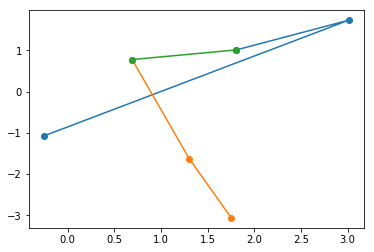

In [187]:
x,y=np.array(net.v_embeddings.weight.data.tolist()).T

plt.plot(x[:3], y[:3], 'o-')
plt.plot(x[3:], y[3:], 'o-')
plt.plot(x[2:4], y[2:4], 'o-')

plt.show()

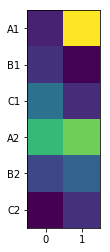

In [186]:
emb_mat=np.array(net.v_embeddings.weight.data.tolist())
emb_mat = np.abs(emb_mat) / np.sum(emb_mat ** 2, axis=1).reshape(-1,1)

fig, ax = plt.subplots(1,1)
img = ax.imshow(emb_mat)
y_label_list = ['A1', 'B1', 'C1', 'A2', 'B2', 'C2']
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels(y_label_list)
plt.show()

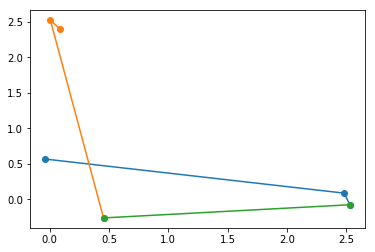

In [191]:
x,y=np.array(net.v_embeddings.weight.data.tolist()).T

plt.plot(x[:3], y[:3], 'o-')
plt.plot(x[3:], y[3:], 'o-')
plt.plot(x[2:4], y[2:4], 'o-')

plt.show()

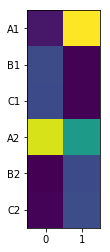

In [194]:
emb_mat=np.array(net.v_embeddings.weight.data.tolist())
emb_mat = np.abs(emb_mat) / np.sum(emb_mat ** 2, axis=1).reshape(-1,1)

fig, ax = plt.subplots(1,1)
img = ax.imshow(emb_mat)
y_label_list = ['A1', 'B1', 'C1', 'A2', 'B2', 'C2']
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels(y_label_list)
plt.show()

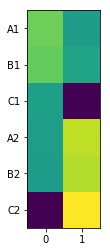

In [159]:
emb_mat=np.array(net.u_embeddings.weight.data.tolist())

fig, ax = plt.subplots(1,1)
img = ax.imshow(emb_mat)
y_label_list = ['A1', 'B1', 'C1', 'A2', 'B2', 'C2']
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels(y_label_list)
plt.show()